In [1]:
#Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Read and explore the dataset. (Rename column, plot histograms, find data characteristics)

In [2]:
ratings=pd.read_csv('ratings_Electronics.csv',header=None)
ratings.head()

0           1    2           3
0   AKM1MP6P0OYPR  0132793040  5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944  5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341  1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341  3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341  1.0  1334707200

In [3]:
ratings.columns=['userID','productID','rating','reviewTime']
ratings.shape

(7824482, 4)

In [4]:
#dropping reviewTime
ratings=ratings.drop(columns=['reviewTime'])
ratings.head()

userID   productID  rating
0   AKM1MP6P0OYPR  0132793040     5.0
1  A2CX7LUOHB2NDG  0321732944     5.0
2  A2NWSAGRHCP8N5  0439886341     1.0
3  A2WNBOD3WNDNKT  0439886341     3.0
4  A1GI0U4ZRJA8WN  0439886341     1.0

In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userID       object
productID    object
rating       float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


rating    count      prop
0     5.0  4347541  0.555633
1     4.0  1485781  0.189889
2     1.0   901765  0.115249
3     3.0   633073  0.080909
4     2.0   456322  0.058320

<function matplotlib.pyplot.show(*args, **kw)>

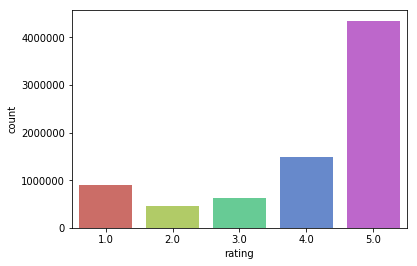

In [6]:
import seaborn as sns
from IPython.display import display
ratings_new=ratings
target_var='rating'

# ploting the data distribution for the target columns "class"
freq = ratings_new[target_var].value_counts().to_frame()
freq.reset_index(inplace=True)
freq.columns = [freq.columns[1], 'count']
freq['prop'] = freq['count'] / sum(freq['count'])
display(freq)
sns.countplot(x=target_var,data=ratings_new,palette='hls')
plt.show

In [8]:
ratings_new.describe(include='all').T

count   unique            top   freq     mean      std  min  \
userID         7824482  4201696  A5JLAU2ARJ0BO    520      NaN      NaN  NaN   
productID      7824482   476002     B0074BW614  18244      NaN      NaN  NaN   
rating     7.82448e+06      NaN            NaN    NaN  4.01234  1.38091    1   

           25%  50%  75%  max  
userID     NaN  NaN  NaN  NaN  
productID  NaN  NaN  NaN  NaN  
rating       3    5    5    5

#### From the histogram and descptive stats, i can observe that
1) There are 42,01,696 unique reviewers. <br>
2) There are 4,76,002 unique products. <br>
3) Rating ranges from 1 to 5. <br>
4) Rating 4 and 5 are higher comparitive to other rating, however, each rating has comparivetly higher for analysis purpose.

### 2. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings )

In [12]:
review_50 = pd.DataFrame(ratings_new.userID.value_counts()>50)

In [14]:
review_50=review_50[review_50.userID==True]

In [15]:
ratings_new = pd.DataFrame(review_50.index,columns=["userID"])

In [16]:
print(ratings_new.head(), ratings_new.shape)

           userID
0   A5JLAU2ARJ0BO
1    ADLVFFE4VBT8
2  A3OXHLG6DIBRW8
3    A6FIAB28IS79
4   A680RUE1FDO8B (1466, 1)


In [17]:
data_set_50 = pd.merge(ratings_new,ratings,left_on='userID',right_on='userID',how='inner')

In [18]:
data_set_50.shape

(122171, 3)

In [19]:
data_set_50.head()

userID   productID  rating
0  A5JLAU2ARJ0BO  1400532655     1.0
1  A5JLAU2ARJ0BO  B00003006R     5.0
2  A5JLAU2ARJ0BO  B00003G1RG     3.0
3  A5JLAU2ARJ0BO  B00004S9AK     5.0
4  A5JLAU2ARJ0BO  B00004SB92     4.0

In [20]:
data_set_50.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122171 entries, 0 to 122170
Data columns (total 3 columns):
userID       122171 non-null object
productID    122171 non-null object
rating       122171 non-null float64
dtypes: float64(1), object(2)
memory usage: 3.7+ MB


In [21]:
data_set_50.describe(include='all').T

count unique            top freq     mean      std  min  25%  50%  \
userID     122171   1466  A5JLAU2ARJ0BO  520      NaN      NaN  NaN  NaN  NaN   
productID  122171  47155     B0088CJT4U  204      NaN      NaN  NaN  NaN  NaN   
rating     122171    NaN            NaN  NaN  4.26262  1.05883    1    4    5   

           75%  max  
userID     NaN  NaN  
productID  NaN  NaN  
rating       5    5

In [22]:
data_set_50.isna().sum()

userID       0
productID    0
rating       0
dtype: int64

### There are 1,466 reviewers who have provided 50 or more number of ratings, ranging from 1 to 5 rating with 1,221,71 observations on 47,155 products.

In [23]:
from surprise import Dataset,Reader
reader = Reader(rating_scale=(1, 5))

In [24]:
data = Dataset.load_from_df(data_set_50[['userID', 'productID', 'rating']], reader)

In [25]:
data

In [26]:
from surprise import KNNWithMeans
from surprise import SVD
from surprise import accuracy
from surprise import Prediction
from surprise.model_selection import cross_validate

In [27]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNWithMeans()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


test_rmse   fit_time  test_time
Algorithm                                    
SVD            0.984390  11.461129   0.786501
KNNWithMeans   1.065774   0.286880   1.796043

### SVD algorithum gave best rmse, thus considered SVD for this project

### Spliting the dataset

In [28]:
# Split data to train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25,random_state=123)

In [29]:
type(trainset)

surprise.trainset.Trainset

In [ ]:
#    1) Trainset is no longer a pandas dataframe. Rather, it's a specific datatypes defined by the Surprise library
#    2) UserId and ItemId in the pandas dataframe can contain any value (either string/integer etc). However, Trainset convert these raw ids into numeric indexes called as "inner id"
#    3) Methods are provided to convert rw id to inner id and vice verca

#### Training the model

In [30]:
#SVD
svd_model = SVD(n_factors=50,biased=False)
svd_model.fit(trainset)

In [31]:
test_pred = svd_model.test(testset)

In [32]:
test_pred_df = pd.DataFrame([[x.uid,x.iid,x.est] for x in test_pred])

In [33]:
test_pred_df.head()

0           1         2
0  A3QDMDSANPYGUX  B001W28L2Y  2.780046
1  A1X1CEGHTHMBL1  B00BZ7MALY  1.670690
2   AGR1V15L6FLMA  B002YIG9AQ  3.743767
3   ABDR6IJ93HFIO  B008HQ1M3I  4.262878
4  A3GVXKCTFN3YDN  B007W0XHK6  5.000000

In [34]:
test_pred_df.columns = ["userID","productID","rating"]
test_pred_df.sort_values(by = ["userID", "rating"],ascending=False,inplace=True)

In [35]:
test_pred_df.head()

userID   productID    rating
733    AZOK5STV85FBJ  B000EDMPQK  4.262878
2176   AZOK5STV85FBJ  B00A85ANCW  4.262878
4133   AZOK5STV85FBJ  B003AXAAWW  4.262878
12107  AZOK5STV85FBJ  B000E922SA  4.262878
17323  AZOK5STV85FBJ  B000VS7XY2  4.262878

In [37]:
top_10_recos = test_pred_df.groupby("userID").head(10).reset_index(drop=True)

In [38]:
top_10_recos.head(30)

userID   productID    rating
0   AZOK5STV85FBJ  B000EDMPQK  4.262878
1   AZOK5STV85FBJ  B00A85ANCW  4.262878
2   AZOK5STV85FBJ  B003AXAAWW  4.262878
3   AZOK5STV85FBJ  B000E922SA  4.262878
4   AZOK5STV85FBJ  B000VS7XY2  4.262878
5   AZOK5STV85FBJ  B001TH7GUU  3.695414
6   AZOK5STV85FBJ  B0002L5R78  1.791786
7   AZOK5STV85FBJ  B00005854B  1.447724
8   AZOK5STV85FBJ  B000XYYDYW  1.198033
9   AZOK5STV85FBJ  B0002BA570  1.000000
10  AZNUHQSHZHSUE  B000FLWC9G  4.262878
11  AZNUHQSHZHSUE  B000A6AXHE  4.262878
12  AZNUHQSHZHSUE  B0002ZG62E  4.262878
13  AZNUHQSHZHSUE  B0032HI3HU  4.262878
14  AZNUHQSHZHSUE  B00006B7DA  4.225060
15  AZNUHQSHZHSUE  B000N99BBC  3.513384
16  AZNUHQSHZHSUE  B003XE3X8Q  3.412094
17  AZNUHQSHZHSUE  B005UA65YA  2.664417
18  AZNUHQSHZHSUE  B000VNJD18  2.476536
19  AZNUHQSHZHSUE  B001U3ZVQ4  2.089050
20  AZMY6E8B52L2T  B003ES5ZUU  5.000000
21  AZMY6E8B52L2T  B00E362W9O  4.876203
22  AZMY6E8B52L2T  B000Q8UAWY  4.863632
23  AZMY6E8B52L2T  B0082E9K7U  4.730180
24  AZMY6E8B52L2T  B00G500AE0  4.722208
25  AZMY6E8B52L2T  B004G6002M  4.710977
26  AZMY6E8B52L2T  B00JX1ZS5O  4.658803
27  AZMY6E8B52L2T  B004R7P28W  4.458523
28  AZMY6E8B52L2T  B008BGXZV6  4.262878
29  AZMY6E8B52L2T  B00IL5E2DW  4.262878

In [39]:
# compute RMSE
accuracy.rmse(test_pred)

RMSE: 1.9881


1.9881194419133057